In [10]:
import preprocessor
import demoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [11]:
# Load BERTweet model and tokenizer
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Load your dataset with columns 'tweet' and 'categories'
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')
print(dataset.columns)
print(dataset.shape)
print(dataset.head(10))

Index(['label', 'tweet', 'label_category'], dtype='object')
(24783, 3)
   label                                              tweet  \
0      2  !!! rt @mayasolovely: as a woman you shouldn't...   
1      1  !!!!! rt @mleew17: boy dats cold...tyga dwn ba...   
2      1  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...   
3      1  !!!!!!!!! rt @c_g_anderson: @viva_based she lo...   
4      1  !!!!!!!!!!!!! rt @shenikaroberts: the shit you...   
5      1  !!!!!!!!!!!!!!!!!!"@t_madison_x: the shit just...   
6      1  !!!!!!"@__brighterdays: i can not just sit up ...   
7      1  !!!!“@selfiequeenbri: cause i'm tired of you b...   
8      1  " & you might not get ya bitch back & thats th...   
9      1  " @rhythmixx_ :hobbies include: fighting maria...   

       label_category  
0             Neutral  
1  Offensive Language  
2  Offensive Language  
3  Offensive Language  
4  Offensive Language  
5  Offensive Language  
6  Offensive Language  
7  Offensive Language  
8  Offensive Langua

In [13]:
# Load and preprocess your dataset
def preprocess_text(text):
    # Use tweet-preprocessor to clean tweets
    cleaned_text = preprocessor.clean(text)
    # Remove emojis
    cleaned_text = remove_emojis(cleaned_text)
    return cleaned_text

def remove_emojis(text):
    return demoji.replace(text, '')

# Preprocess text
dataset['cleaned_tweet'] = dataset['tweet'].apply(preprocess_text)

print(dataset.columns)
print(dataset.shape)
# print(dataset.head(10))

Index(['label', 'tweet', 'label_category', 'cleaned_tweet'], dtype='object')
(24783, 4)


In [14]:
# Split the dataset into training and testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(
    dataset['cleaned_tweet'],  # Features
    dataset['label'],  # Labels
    test_size=0.4, 
    random_state=42
)

# Split the testing set into validation (50%) and testing (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_temp,
    y_test_temp,
    test_size=0.5,
    random_state=42
)

# Reset the index to ensure it is consecutive
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Print the sizes of each set: Training 60% / Val 20% / Testing 20% 
print("Training set size:", len(X_train), "(Hate Speech: ", sum(y_train == 0), ", Offensive Language: ", sum(y_train == 1), ", Neutral: ", sum(y_train == 2), ")")
print("Validation set size:", len(X_val), "(Hate Speech: ", sum(y_val == 0), ", Offensive Language: ", sum(y_val == 1), ", Neutral: ", sum(y_val == 2), ")")
print("Testing set size:", len(X_test), "(Hate Speech: ", sum(y_test == 0), ", Offensive Language: ", sum(y_test == 1), ", Neutral: ", sum(y_test == 2),")")

Training set size: 14869 (Hate Speech:  858 , Offensive Language:  11526 , Neutral:  2485 )
Validation set size: 4957 (Hate Speech:  297 , Offensive Language:  3797 , Neutral:  863 )
Testing set size: 4957 (Hate Speech:  275 , Offensive Language:  3867 , Neutral:  815 )


In [16]:
# print type for train, val, and test, also the shape
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(X_val), X_val.shape)
print(type(y_val), y_val.shape)
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)
print(X_train.head(10))
print(y_train.head(10))

<class 'pandas.core.series.Series'> (14869,)
<class 'pandas.core.series.Series'> (14869,)
<class 'pandas.core.series.Series'> (4957,)
<class 'pandas.core.series.Series'> (4957,)
<class 'pandas.core.series.Series'> (4957,)
<class 'pandas.core.series.Series'> (4957,)
0                         that pussy came gift wrapped
1    lmaoooort remember when y'all bitches were lot...
2    : where do all the foreskins go when they circ...
3    now we have a ebloa case in texas. if we kill ...
4                so, about this flappy bird game then.
5    patrick you ain't nottin but a hood nigga top ...
6                        fuck all y'all hoes gang shit
7    : some of yall hoes nasty yall find out yall s...
8                                     ....so ur a fag?
9                              rt : anxiety is a bitch
Name: cleaned_tweet, dtype: object
0    1
1    1
2    2
3    0
4    2
5    1
6    1
7    1
8    1
9    1
Name: label, dtype: int64


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Fit TF-IDF vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTE to balance the dataset
# smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)
# X_train_smote, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
# print("Resampled Training set size:", X_train_smote.shape[0], "(Hate Speech: ", sum(y_train_resampled == 0), ", Offensive Language: ", sum(y_train_resampled == 1), ", Neutral: ", sum(y_train_resampled == 2), ")")

# Apply ENN to balance the dataset
enn = EditedNearestNeighbours(kind_sel='mode', n_neighbors=5)
X_train_enn, y_train_resampled = enn.fit_resample(X_train_tfidf, y_train)
print("Resampled Training set size:", X_train_enn.shape[0], "(Hate Speech: ", sum(y_train_resampled == 0), ", Offensive Language: ", sum(y_train_resampled == 1), ", Neutral: ", sum(y_train_resampled == 2), ")")

# Apply SMOTEENN to balance the dataset
# smote_enn = SMOTEENN(random_state=42, 
#                      n_jobs=-1, 
#                      sampling_strategy='auto', 
#                      smote=SMOTE(sampling_strategy='auto', k_neighbors=5), 
#                      enn=EditedNearestNeighbours(kind_sel='mode', n_neighbors=3))
# X_train_smote_enn, y_train_resampled = smote_enn.fit_resample(X_train_tfidf, y_train)
# print("Resampled Training set size:", X_train_smote_enn.shape[0], "(Hate Speech: ", sum(y_train_resampled == 0), ", Offensive Language: ", sum(y_train_resampled == 1), ", Neutral: ", sum(y_train_resampled == 2), ")")

Resampled Training set size: 2693 (Hate Speech:  858 , Offensive Language:  1728 , Neutral:  107 )


In [7]:
# Convert TF-IDF transformed data back to text
X_train_resampled_text = tfidf_vectorizer.inverse_transform(X_train_enn)

# Concatenate the tokens to form sentences
X_train_resampled_text = [' '.join(tokens) for tokens in X_train_resampled_text]

# Convert the list of tokenized sentences back into a Series
X_train_resampled = pd.Series(X_train_resampled_text, name='X_train_resampled')

# Tokenize the balanced training data using BERTweet
tokenized_resampled_train = pd.DataFrame({'tweet': X_train_resampled, 'label': y_train_resampled})
# shuffle the data
tokenized_resampled_train = tokenized_resampled_train.sample(frac=1).reset_index(drop=True)
print(tokenized_resampled_train.head(10))

                                               tweet  label
0                              re fucking faggot you      0
1                    idc none these of about bitches      1
2                    coming httpurl not rt bitch you      1
3                                      is rt bitches      1
4  live these wrong httpurl what man lol with bit...      1
5                                       free rt bird      2
6           discover boys httpurl hoe rt ur and when      1
7  playin knows place folk colored only white wit...      0
8  song black httpurl come drive how on they bitc...      1
9  taking shame chill campus walk wants throw who...      0


In [14]:
def tokenize_data(text):
    return tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
# Tokenize and prepare input data for training set
tokenized_train = X_train_resampled.apply(tokenize_data)
print("Training set size: ", len(tokenized_train))
print(tokenized_train.head(3))
tokenized_val = X_val.apply(tokenize_data)
print("Validation set size: ", len(tokenized_val))
print(tokenized_val.head(3))
tokenized_test = X_test.apply(tokenize_data)
print("Testing set size: ", len(tokenized_test))
print(tokenized_test.head(3))

Training set size:  2693
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: X_train_resampled, dtype: object
Validation set size:  4957
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, dtype: object
Testing set size:  4957
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, dtype: object


In [15]:
# Create DataLoader for training set
input_ids_train = torch.cat([tokenized_train[i]['input_ids'] for i in range(len(tokenized_train))], dim=0)
attention_masks_train = torch.cat([tokenized_train[i]['attention_mask'] for i in range(len(tokenized_train))], dim=0)
labels_train = torch.tensor(y_train_resampled.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

# Create DataLoader for validation set
input_ids_val = torch.cat([tokenized_val[i]['input_ids'] for i in range(len(tokenized_val))], dim=0)
attention_masks_val = torch.cat([tokenized_val[i]['attention_mask'] for i in range(len(tokenized_val))], dim=0)
labels_val = torch.tensor(y_val.values)

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=False)

# Create DataLoader for testing set
input_ids_test = torch.cat([tokenized_test[i]['input_ids'] for i in range(len(tokenized_test))], dim=0)
attention_masks_test = torch.cat([tokenized_test[i]['attention_mask'] for i in range(len(tokenized_test))], dim=0)
labels_test = torch.tensor(y_test.values)

# Create DataLoader for testing set
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

In [16]:
# Set up optimizer for full fine-tuning
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# Set up optimizer for partial fine-tuning
optimizer = torch.optim.AdamW(
    [
        {"params": model.roberta.encoder.layer[-4:].parameters(), "lr": 1e-5},  # Only fine-tune the last 4 layers
        {"params": model.classifier.parameters(), "lr": 1e-3}  # Fine-tune the classifier layer with a higher learning rate
    ]
)

# Set up training parameters
num_epochs = 5  # You can adjust this based on your requirements
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model and data to the device
model.to(device)
input_ids_train, attention_masks_train, labels_train = input_ids_train.to(device), attention_masks_train.to(device), labels_train.to(device)
input_ids_val, attention_masks_val, labels_val = input_ids_val.to(device), attention_masks_val.to(device), labels_val.to(device)
loss_per_epoch = {'train': [], 'val': []}
accuracy_per_epoch = {'train': [], 'val': []}

Training Epoch 1/5: 100%|██████████| 169/169 [07:24<00:00,  2.63s/it]


Epoch 1/5, Train Loss: 0.5654284714682568, Train Accuracy: 0.7682881544745637


Validation Epoch 1/5: 100%|██████████| 310/310 [04:09<00:00,  1.24it/s]


Epoch 1/5, Validation Loss: 0.977557387178944, Validation Accuracy: 0.7012305830139197


Training Epoch 2/5: 100%|██████████| 169/169 [07:06<00:00,  2.52s/it]


Epoch 2/5, Train Loss: 0.3870537035034958, Train Accuracy: 0.8384701076865949


Validation Epoch 2/5: 100%|██████████| 310/310 [03:39<00:00,  1.41it/s]


Epoch 2/5, Validation Loss: 0.7155326629357953, Validation Accuracy: 0.7101069195077668


Training Epoch 3/5: 100%|██████████| 169/169 [07:04<00:00,  2.51s/it]


Epoch 3/5, Train Loss: 0.32688828478374427, Train Accuracy: 0.8644634236910509


Validation Epoch 3/5: 100%|██████████| 310/310 [03:49<00:00,  1.35it/s]


Epoch 3/5, Validation Loss: 0.6196539839188899, Validation Accuracy: 0.7569094210207787


Training Epoch 4/5: 100%|██████████| 169/169 [07:46<00:00,  2.76s/it]


Epoch 4/5, Train Loss: 0.30987016318542276, Train Accuracy: 0.8718900854066097


Validation Epoch 4/5: 100%|██████████| 310/310 [03:49<00:00,  1.35it/s]


Epoch 4/5, Validation Loss: 0.6501581026421439, Validation Accuracy: 0.7389550131127698
No improvement in validation loss for 4 epochs. Stopping training.


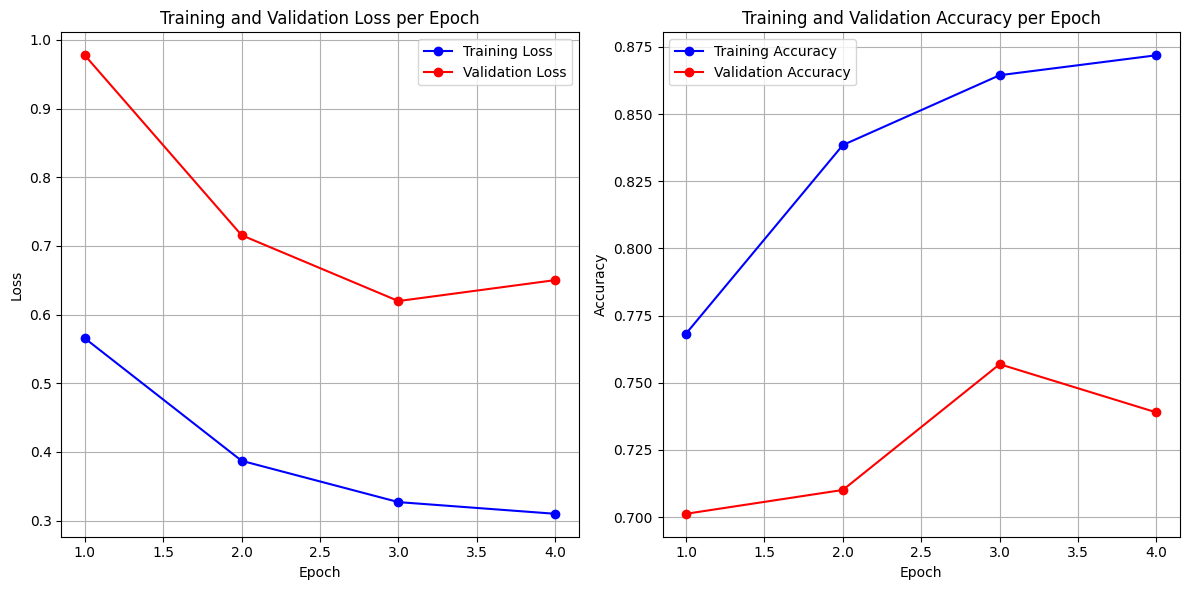

In [17]:
# Model Training
best_val_loss = np.Inf  # Initialize with a very large value for early stopping

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(dataloader_train, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        batch_input_ids, batch_attention_masks, batch_labels = (
            batch_input_ids.to(device),
            batch_attention_masks.to(device),
            batch_labels.to(device),
        )

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks,
            labels=batch_labels,
        )

        # Calculate loss
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted_labels = torch.max(outputs.logits, 1)
        # print(predicted_labels)
        # print(batch_labels)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    # Calculate accuracy for the training epoch
    accuracy_train = correct_predictions / total_samples
    accuracy_per_epoch['train'].append(accuracy_train)

    # Calculate average loss for the training epoch
    average_loss_train = total_loss / len(dataloader_train)
    loss_per_epoch['train'].append(average_loss_train)
   
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    total_loss_val = 0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for batch_val in tqdm(dataloader_val, desc=f'Validation Epoch {epoch + 1}/{num_epochs}'):
            batch_input_ids, batch_attention_masks, batch_labels = batch_val
            batch_input_ids, batch_attention_masks, batch_labels = (
                batch_input_ids.to(device),
                batch_attention_masks.to(device),
                batch_labels.to(device),
            )
            outputs = model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_masks,
                    labels=batch_labels,
                )

            loss_val = outputs.loss
            total_loss_val += loss_val.item()

            _, predicted_labels_val = torch.max(outputs.logits, 1)
            correct_predictions_val += (predicted_labels_val == batch_labels).sum().item()
            total_samples_val += batch_labels.size(0)

    # Calculate accuracy for the validation epoch
    accuracy_val = correct_predictions_val / total_samples_val
    accuracy_per_epoch['val'].append(accuracy_val)

    # Calculate average loss for the validation epoch
    average_loss_val = total_loss_val / len(dataloader_val)
    loss_per_epoch['val'].append(average_loss_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_loss_val}, Validation Accuracy: {accuracy_val}")
    
    # Early stopping logic
    if average_loss_val < best_val_loss:
        best_val_loss = average_loss_val
    else:
        print(f"No improvement in validation loss for {epoch + 1} epochs. Stopping training.")
        break  # Exit training loop if early stopping condition is met

# Save the trained model (This method is specific to the transformers library and is designed for saving transformer-based models.)
# It saves the model in a format that includes the architecture, parameters, and additional information specific to the transformers library.
# It provides a higher-level abstraction that is specific to transformer models and allows for easily loading the model using AutoModelForSequenceClassification.from_pretrained later.
model.save_pretrained("./model/BERTweet model_multiclass_v9")
tokenizer.save_pretrained("./model/BERTweet model_multiclass_v9")

executed_epochs = len(loss_per_epoch['train'])

# Plot the loss values
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, executed_epochs + 1), loss_per_epoch['train'], label='Training Loss', marker='o', linestyle='-', color='b')
plt.plot(range(1, executed_epochs + 1), loss_per_epoch['val'], label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, executed_epochs + 1), accuracy_per_epoch['train'], label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, executed_epochs + 1), accuracy_per_epoch['val'], label='Validation Accuracy', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
# trained model
# lr = 5e-5
# batch size = 32
# epoch = 5
# total training time = 331 mins
# optimizer = AdamW

# Load the BERTweet tokenizer and model for making predictions on the testing dataset
model_paths = {
    "smote_enn": "./model/BERTweet model_multiclass_v7",
    "enn": "./model/BERTweet model_multiclass_v9",
    "smote": "./model/BERTweet model_multiclass_v8"
}

models = {}
tokenizers = {}

for model_name, model_path in model_paths.items():
    tokenizers[model_name] = AutoTokenizer.from_pretrained(model_path)
    models[model_name] = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)


BERTweet_Smote_enn:
                     precision    recall  f1-score   support

        Hate Speech       0.09      0.83      0.16       275
Offensive Languages       0.99      0.24      0.39      3867
            Neutral       0.53      0.94      0.68       815

           accuracy                           0.39      4957
          macro avg       0.54      0.67      0.41      4957
       weighted avg       0.87      0.39      0.43      4957



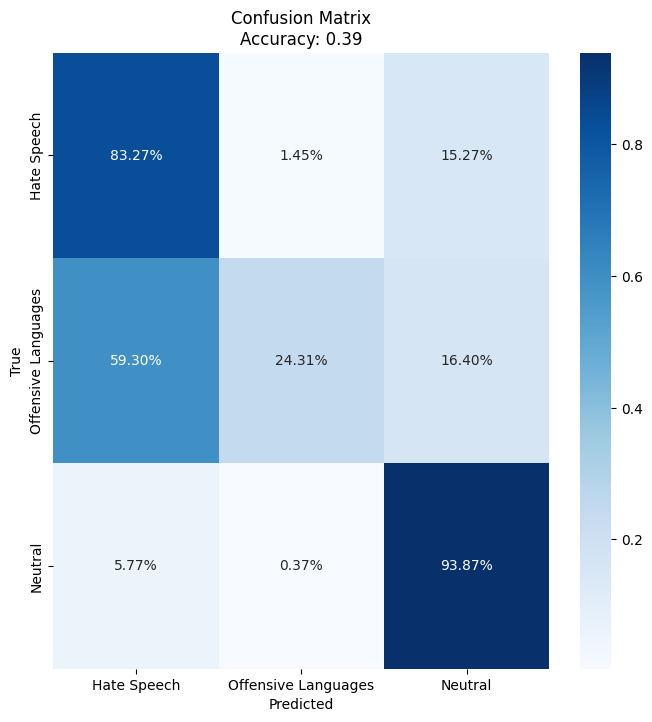

BERTweet_Enn:
                     precision    recall  f1-score   support

        Hate Speech       0.15      0.63      0.24       275
Offensive Languages       0.94      0.81      0.87      3867
            Neutral       0.79      0.47      0.59       815

           accuracy                           0.74      4957
          macro avg       0.63      0.64      0.57      4957
       weighted avg       0.87      0.74      0.79      4957



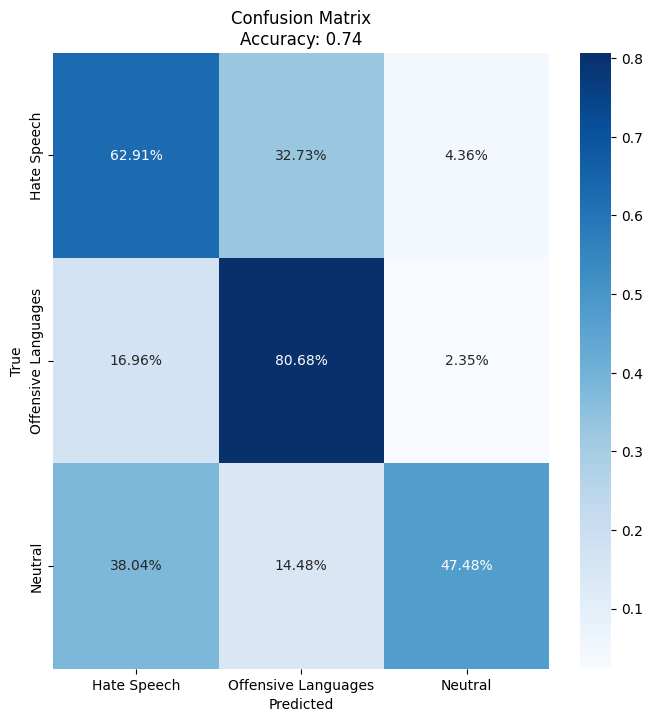

BERTweet_Smote:
                     precision    recall  f1-score   support

        Hate Speech       0.12      0.65      0.21       275
Offensive Languages       0.97      0.55      0.70      3867
            Neutral       0.57      0.95      0.72       815

           accuracy                           0.62      4957
          macro avg       0.56      0.72      0.54      4957
       weighted avg       0.86      0.62      0.68      4957



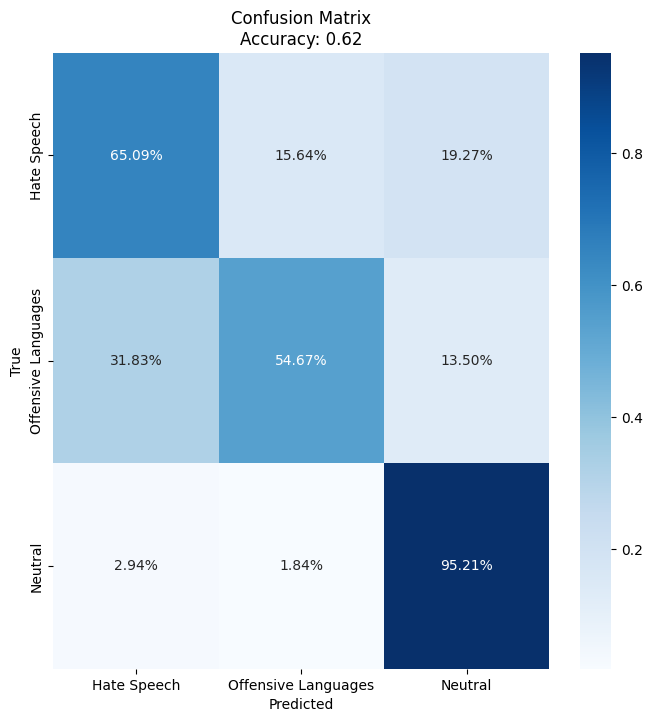

In [19]:
# Model Evaluation
label_dict = {'Hate Speech': 0, 'Offensive Languages': 1, 'Neutral': 2}

for model_name, model in models.items():
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in dataloader_test:
            input_ids, attention_masks, labels = [tensor.to(device) for tensor in batch]

            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)

    # Evaluate the model
    print(f"BERTweet_{model_name.capitalize()}:")
    print(classification_report(y_test, all_preds, target_names=label_dict.keys()))

    # Generate confusion matrix
    conf_mat = confusion_matrix(y_test, all_preds, normalize='true')
    accuracy_bertweet = accuracy_score(y_test, all_preds)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 8))
    # sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='.2%', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy_bertweet:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
